In [3]:
import os
import time
from obspy import read, Stream, Trace
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib

In [2]:
def generate_predictions(window, model, look_back, num_iterations=1000):
    # Normalise and  Reshape the initial window
    window = scale_data(window, scaler)
    window = np.reshape(window, (1, look_back, 1))
    

    # Pre-allocate the array to store all windows
    all_windows = np.zeros((num_iterations, look_back, 1))

    # Fill the first window
    all_windows[0] = window

    # Initialize the predictions list
    predictions = []

    # Loop to add predicted values
    for i in range(0, num_iterations-1):
        predicted_value = model.predict(all_windows[i:i+1])  # Example predicted value
        predictions.append(predicted_value[0])
        predicted_value = predicted_value.reshape(1, 1, 1)  # Ensure shape is (1, 1, 1)
        new_window = np.concatenate((all_windows[i:i+1], predicted_value), axis=1)
        all_windows[i+1] = new_window[:, -look_back:, :]  # Keep the last 100 elements

    predictions = inverse_scaler(predictions, scaler)
    return predictions

In [3]:
def get_data(st):
    """Take a stream, fill gap with interpolate  and return  data"""
    st =  st.merge(method=1, fill_value='interpolate')
    tr = st[0]
    data = tr.data.astype(np.float32).reshape(-1, 1)
    return data

In [4]:
#removed the normalisation in the function
def create_windowed_dataset(data, look_back=1, horizon=1, batch_size=32, shift=1):    
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(data)
    
    # Create windows
    dataset = dataset.window(look_back + horizon, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(look_back+ horizon))
    
    # Split into input and output
    dataset = dataset.map(lambda window: (window[:-horizon], window[-horizon:]))
    
    # batch the dataset
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [5]:

def fit_scaler(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = data.reshape(-1, 1)
    scaler.fit(data)
    return scaler

def scale_data(data, scaler):
    scaled_data = scaler.transform(data)
    return scaled_data

def inverse_scaler(scaled_data, scaler):
    scaled_data = scaled_data.reshape(-1, 1)
    restored_data = scaler.inverse_transform(scaled_data)
    return restored_data

In [6]:
def prediction_output(window, model, look_back):
    # Normalise and  Reshape the initial window
    window = scale_data(window, scaler)
    window = np.reshape(window, (1, look_back, 1))

    predicted_value = model.predict(window, verbose = 0)  # Example predicted value

    predictions = inverse_scaler(predicted_value, scaler)
    return predictions

In [12]:
#Full Year
st = read("Data/MX_MOIG_BHZ_2023-01-01_2024-01-01.mseed")
#data = st[0].data
#scaler = fit_scaler(data)

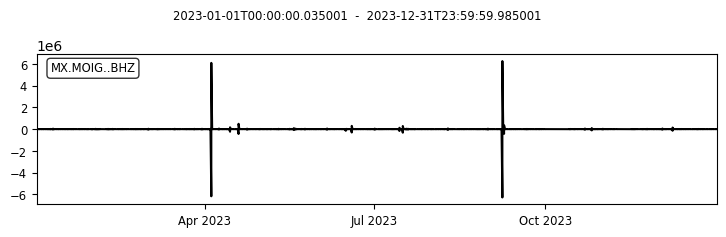

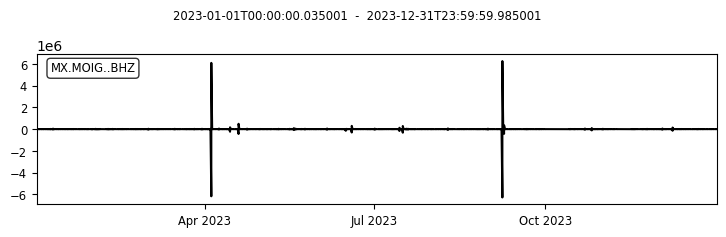

In [11]:
st.plot()

In [8]:
data = get_data(st)

In [9]:
scaler = joblib.load('scaler.save')

In [13]:
scaled_data = scale_data(data, scaler)

In [14]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [15]:
look_back = 2000
batch_size = 5
shift = 1
horizon = 600

In [16]:
train_dataset = create_windowed_dataset(
    train_data, look_back, horizon, batch_size, shift
)
validation_dataset = create_windowed_dataset(
    test_data, look_back, horizon, batch_size, shift
)

In [18]:
max_steps = (len(train_data)//((look_back+horizon)*batch_size))-1
max_steps

43664

In [19]:
#Create and fit LSTM model
model = Sequential()
model.add(LSTM(64, stateful=True, return_sequences=True, batch_input_shape=(batch_size, look_back, 1)))  # Experiment with units
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(32, stateful=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(horizon))
model.compile(loss='mean_squared_error', optimizer='adam')

# Define the filepath where you want to save the model checkpoints
checkpoint_path = "my_model_checkpoints/model_quick_stateful_i2000_o600_b5_{epoch:02d}.hdf5"

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the entire model, not just weights
    save_freq="epoch",
    )



# Training loop
epochs = 100
steps_per_epoch = 1000
validation_steps = 5

for epoch in range(epochs):
    model.fit(train_dataset,
              epochs=1,
              callbacks=[checkpoint_callback],
              verbose=1,
              steps_per_epoch=steps_per_epoch,
              validation_data=validation_dataset,
              validation_steps=validation_steps)
    model.reset_states()  # Reset states after each epoch

1000/1000 [==============================] - 209s 209ms/step - loss: 2.3571e-05 - val_loss: 1.9220e-05


In [21]:
model.save('last_model_stateful_i2000_600_b5')

INFO:tensorflow:Assets written to: last_model_stateful_i2000_600_b5\assets


INFO:tensorflow:Assets written to: last_model_stateful_i2000_600_b5\assets


In [11]:

model = load_model('my_model_checkpoints/final_model_stateful_i2000_o600_b5_01.hdf5')

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Unrecognized keyword arguments passed to LSTM: {'time_major': False}

In [ ]:
va(train_dataset)

    134/Unknown - 21s 137ms/step - loss: 1.7976e-05

In [28]:
time_steps = look_back
test_steps = 20

predictions = model.predict(test_data, steps=test_steps)

# Extract actual values
X_test, y_test = next(iter(validation_dataset))

# Adjust y_test to match the length of predictions
y_test = y_test[time_steps:time_steps + len(predictions)]

ValueError: in user code:

    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\User\anaconda3\envs\obspy_fix\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (3153600, 1)


ValueError: x and y can be no greater than 2D, but have shapes (0,) and (0, 600, 1)

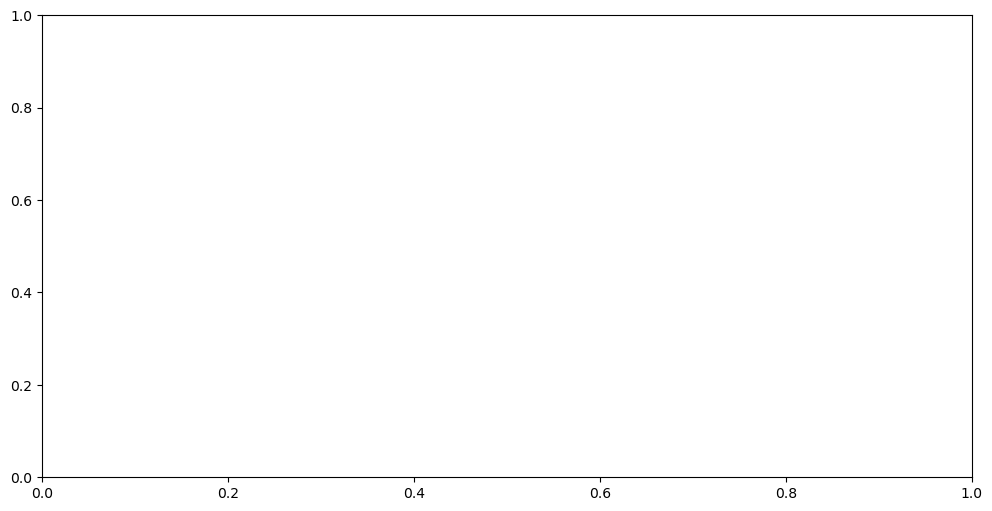

In [25]:
# Extract actual values
X_test, y_test = next(iter(validation_dataset))

# Adjust y_test to match the length of predictions
y_test = y_test[time_steps:time_steps + len(predictions)]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions[0], label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [30]:
# Extract actual values
X_test, y_test = next(iter(validation_dataset))

In [37]:
y_test_np = y_test.numpy()

In [40]:
y_test_np = y_test_np.reshape(-1)

In [41]:
y_test_np

array([0.45119452, 0.45015693, 0.44949546, 0.45216727, 0.44998834,
       0.44848382, 0.45097405, 0.45036444, 0.44847086, 0.4482374 ,
       0.4507795 , 0.45259526, 0.44705716, 0.4494047 , 0.4524915 ,
       0.44821146, 0.4487951 , 0.4498197 , 0.45125937, 0.4503385 ,
       0.44675884, 0.44818553, 0.45454073, 0.4505979 , 0.44777048,
       0.4553708 , 0.45302325, 0.45058495, 0.45176518, 0.4507276 ,
       0.45041633, 0.44991052], dtype=float32)

In [43]:
predictions = model.predict(y_test_np)
predictions

ValueError: in user code:

    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (32, 1)


In [ ]:

#model = load_model('my_model_checkpoints/model_AP_MAY_72.hdf5')

In [ ]:
#look_back = 12000
#test_predictions = generate_predictions(scaled_window, model, look_back, num_iterations=100)
#test_predictions
actual = validation_dataset.take(validation_steps)
actual[0]

In [ ]:
# Evaluate the model on the validation dataset
loss = model.evaluate(validation_dataset, steps=validation_steps, verbose=1)
print(f'Validation Loss: {loss}')

# Generate predictions on the validation dataset
predictions = model.predict(validation_dataset, steps=validation_steps)

actual = validation_dataset.take(validation_steps)

#actual = inverse_scale(actual, scaler)

#predicted = inverse_scale(predicted, scaler)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual[0], label='Actual')
plt.plot(predicted[0], label='Predicted', alpha= 0.5)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
actual = inverse_scaler(actual, scaler)
predicted = inverse_scaler(predicted, scaler)

In [ ]:
actual = inverse_scaler(actual, scaler)
predicted = inverse_scaler(predicted, scaler)
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
#plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted', alpha= 0.5)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

look_back = 12000
horizon = 20
predictions = []
window = test_data[0:12000]
scaled_window = scale_data(window, scaler)
# Ensure scaled_window is correctly shaped
new_window = scaled_window.reshape(1, look_back, 1)
window = test_data[0:12000]

for i in range(horizon):
    # Predict the next value
    predicted_value = model.predict(new_window, verbose=1)
    predictions.append(predicted_value[0])
    
    # Update the window with the new prediction
    new_window = np.roll(new_window, -1, axis=1)
    new_window[0, -1, 0] = predicted_value

# Convert predictions to a numpy array for further processing
predictions = inverse_scaler(np.array(predictions), scaler)
print(predictions)

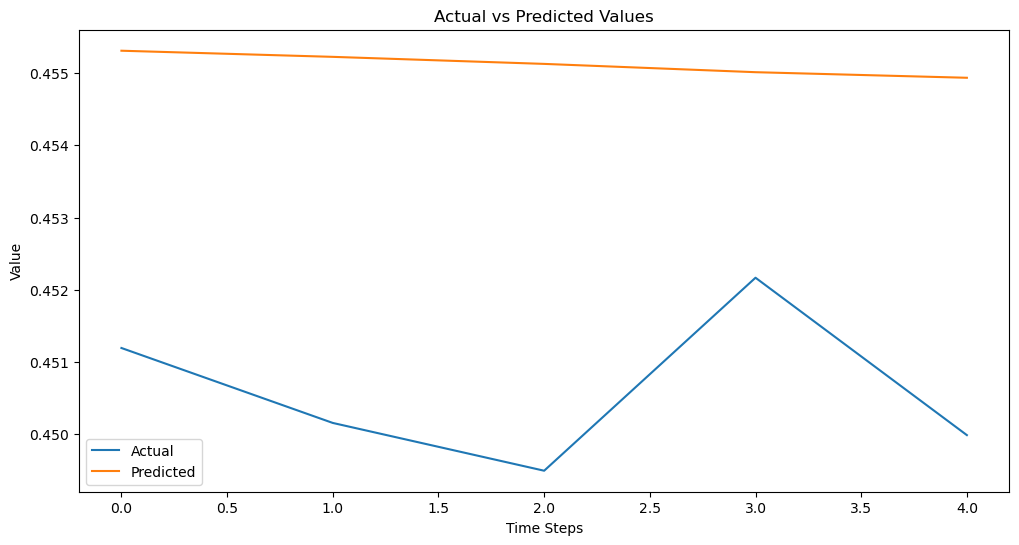

In [66]:
# Generate predictions on the validation dataset
predictions = model.predict(validation_dataset, steps=validation_steps)

# Extract actual values from the validation dataset
actual = []
predicted = []

for batch in validation_dataset.take(validation_steps):
    inputs, targets = batch
    actual.extend(targets.numpy().flatten())  # Flatten the actual values
    predicted.extend(model.predict(inputs).flatten())  # Flatten the predicted values

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
#model = load_model('my_model_checkpoints/model_2023_i600_o20_nobatchnorm_34.hdf5')

In [161]:
window = test_data[:1200]
window = np.reshape(window, (1, look_back, 1))
pred = model.predict(window)
pred.shape

InvalidArgumentError:    Invalid input_h shape: [1,4,64] [1,1,64]
	 [[{{node CudnnRNN}}]]
	 [[sequential_14/lstm_21/PartitionedCall]] [Op:__inference_predict_function_235628]

Function call stack:
predict_function -> predict_function -> predict_function


In [44]:
window = test_data[:600]
window = np.reshape(window, (1, look_back, 1))
actual = test_data[600:620]
prediction = prediction_output(window, model, look_back)

InvalidArgumentError:    Invalid input_h shape: [1,32,64] [1,1,64]
	 [[{{node CudnnRNN}}]]
	 [[sequential_3/lstm_2/PartitionedCall]] [Op:__inference_predict_function_23607]

Function call stack:
predict_function -> predict_function -> predict_function


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(prediction, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [70]:
window.shape
next_prediction = model.predict(window)
next_prediction.shape

(1, 1)

In [68]:

# Assuming model is already defined and trained
# Define the initial input sequence (most recent data points)
initial_input = window  # Shape should be (batch_size, look_back, 1)

# Number of future steps to predict
num_future_steps = 10

# List to store future predictions
future_predictions = []

# Make future predictions
for _ in range(num_future_steps):
    # Predict the next value
    next_prediction = model.predict(initial_input)
    
    # Append the prediction to the list
    future_predictions.append(next_prediction[0, 0])
    
    # Update the input sequence
    initial_input = np.append(initial_input[:, 1:, :], [[next_prediction]], axis=1)

# Convert future predictions to a NumPy array
future_predictions = np.array(future_predictions)

# Print future predictions
print(future_predictions)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [99]:
new_predictions[0].shape

(100,)

In [152]:
model.reset_states()
window = test_data[:1200]
window = np.reshape(window, (1, look_back, 1))
new_input_sequence = window
initial_input = window

# Number of future steps to predict
num_future_steps = 6

# List to store future predictions
future_predictions = []

# Reset the states of the model
model.reset_states()

# Make future predictions
for _ in range(num_future_steps):
    # Predict the next value
    next_prediction = model.predict(initial_input)
    
    # Append the prediction to the list
    future_predictions.append(np.array(next_prediction[0]))
    
    # Update the input sequence
    next_prediction_reshaped = next_prediction.reshape((initial_input.shape[0], horizon, initial_input.shape[2]))
    initial_input = np.append(initial_input[:, 1:, :], next_prediction_reshaped, axis=1)
    initial_input[:, -look_back:, :]
    model.reset_states()

# Convert future predictions to a NumPy array
future_predictions = np.array(future_predictions)

# Print future predictions
print(future_predictions)

InvalidArgumentError:    Invalid input_h shape: [1,4,64] [1,1,64]
	 [[{{node CudnnRNN}}]]
	 [[sequential_14/lstm_21/PartitionedCall]] [Op:__inference_predict_function_235628]

Function call stack:
predict_function -> predict_function -> predict_function


In [141]:
future_predictions = future_predictions.flatten()
future_predictions

array([0.4438657 , 0.453824  , 0.45049745, 0.4459777 , 0.44913897,
       0.44147187, 0.4502954 , 0.44380888, 0.44675004, 0.44497657,
       0.44765297, 0.45636457, 0.4443915 , 0.4409994 , 0.45961002,
       0.45413947, 0.44561636, 0.45311725, 0.4540781 , 0.4475839 ,
       0.44310835, 0.45339337, 0.44966227, 0.44539124, 0.44836462,
       0.44048   , 0.4493955 , 0.4431046 , 0.44619945, 0.444561  ,
       0.44682524, 0.45563918, 0.44336522, 0.43986446, 0.45867655,
       0.45292366, 0.44464168, 0.45221436, 0.45327395, 0.44652236,
       0.44288665, 0.45323572, 0.44942018, 0.4452    , 0.44813573,
       0.44019932, 0.44913602, 0.44289443, 0.44602504, 0.44442287,
       0.44657895, 0.45541725, 0.44308358, 0.43954054, 0.45841622,
       0.45258185, 0.44434735, 0.45196834, 0.45303112, 0.44622934,
       0.44282058, 0.45318842, 0.4493484 , 0.4451429 , 0.4480676 ,
       0.440116  , 0.4490587 , 0.44283164, 0.44597313, 0.4443816 ,
       0.4465056 , 0.45535105, 0.44300067, 0.4394444 , 0.45833

In [162]:
window = test_data[:1200]
window = np.reshape(window, (1, look_back, 1))
window.shape
model.predict_on_batch(window)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_14508\1841524395.py", line 4, in <module>
    model.predict_on_batch(window)
  File "C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\keras\engine\training.py", line 1947, in predict_on_batch
  File "C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    "f()  # <tf.Tensor: numpy=1.>\n"
  File "C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\eager\def_function.py", line 924, in _call
    ])
  File "C:\Users\User\anaconda3\envs\obspy_python38\lib\site-packages\tensorflow\python\eager\function.py", line 3038, in __call__
    in_cross_replica_context = (strategy_stack[-1].replica_context is None)  # pylint: 

In [164]:
model.reset_states()
window = test_data[:4800]
window = np.reshape(window, (batch_size, look_back, 1))
new_input_sequence = window
new_predictions = model.predict(window)
new_predictions

array([[0.4489306 , 0.449409  , 0.44976127, ..., 0.4449784 , 0.44520375,
        0.44534814],
       [0.44893047, 0.44940895, 0.44976124, ..., 0.44497833, 0.4452037 ,
        0.44534805],
       [0.4489308 , 0.4494093 , 0.44976154, ..., 0.444978  , 0.44520348,
        0.44534788],
       [0.44893038, 0.4494088 , 0.44976112, ..., 0.4449785 , 0.4452038 ,
        0.44534817]], dtype=float32)

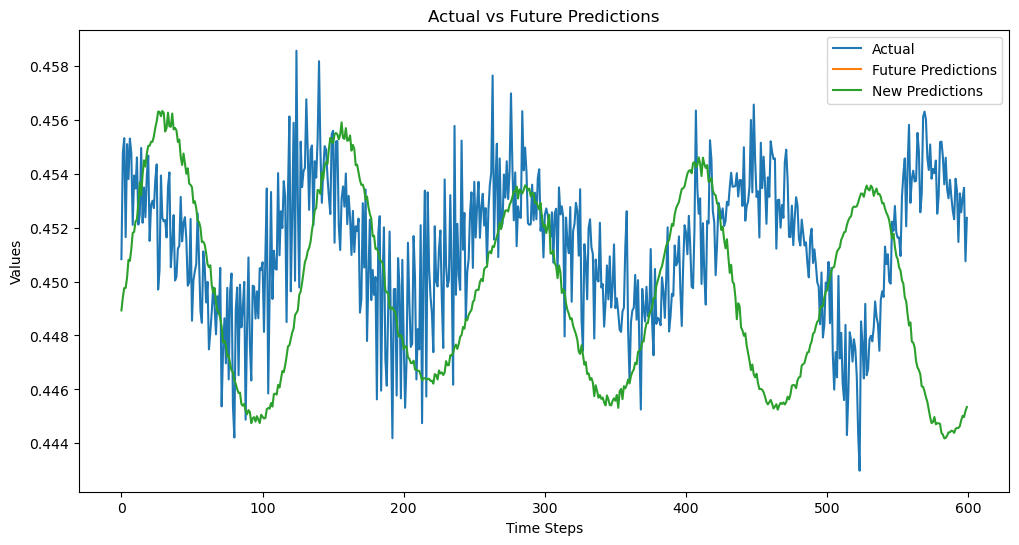

In [166]:
# Assuming y_test contains the actual values
actual = test_data[1200:1800]
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(future_predictions, label='Future Predictions')
plt.plot(new_predictions[0], label='New Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Actual vs Future Predictions')
plt.legend()
plt.show()